<a href="https://colab.research.google.com/github/Parissai/ML-DS-Playground/blob/main/classify_song_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify Song Genres from Audio Data

Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.

For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. This is the examination of data compiled by a research group known as The Echo Nest. The goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock'. In doing so, learn how to clean the data, do some exploratory data visualization, and use feature reduction towards the goal of feeding the data through some simple machine learning algorithms, such as decision trees and logistic regression.

There is another dataset that has musical features of each track such as danceability and acousticness on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('/content/drive/MyDrive/data/fma-rock-vs-hiphop.csv')
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [28]:
# Read in track metrics with the features
echonest_metrics = pd.read_json('/content/drive/MyDrive/data/echonest-metrics.json', precise_float=True)
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [29]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[['track_id', 'genre_top']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


1. Pairwise relationships between continuous variables

  We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:

  - To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
  - When our datasets are very large, using fewer features can drastically speed up our computation time.
  - To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the pandas package.

In [30]:
# Create a correlation matrix
corr_metrics = echo_tracks.select_dtypes(include=['float', 'int']).corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


2. Splitting our data

  It can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particularly strong correlations between our features, we can now split our data into an array containing our features, and another containing the labels - the genre of the track.


In [31]:
from sklearn.model_selection import train_test_split

# Create features
features = echo_tracks.drop(["genre_top", "track_id"], axis=1).values

# Create labels
labels = echo_tracks["genre_top"].values

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=13)

3. Normalizing the feature data

  Using a common approach to reduce the number of features: principal component analysis (PCA).

  It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

  However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. A common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [32]:
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

4. Principal Component Analysis(PCA)

  Using scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

  Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.

Text(0.5, 0, 'Principal Component #')

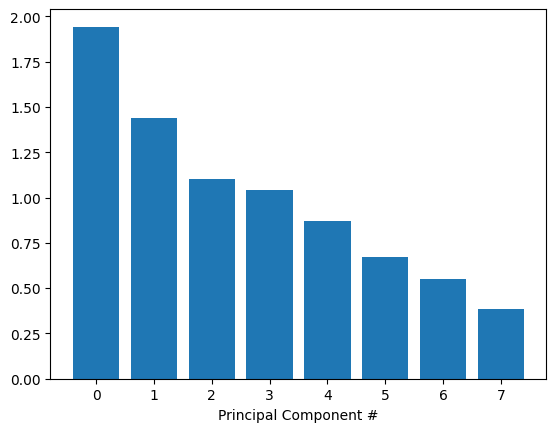

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_) , exp_variance)
ax.set_xlabel('Principal Component #')

5. Further visualization of PCA

  Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

  So instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain about 85% of the variance.

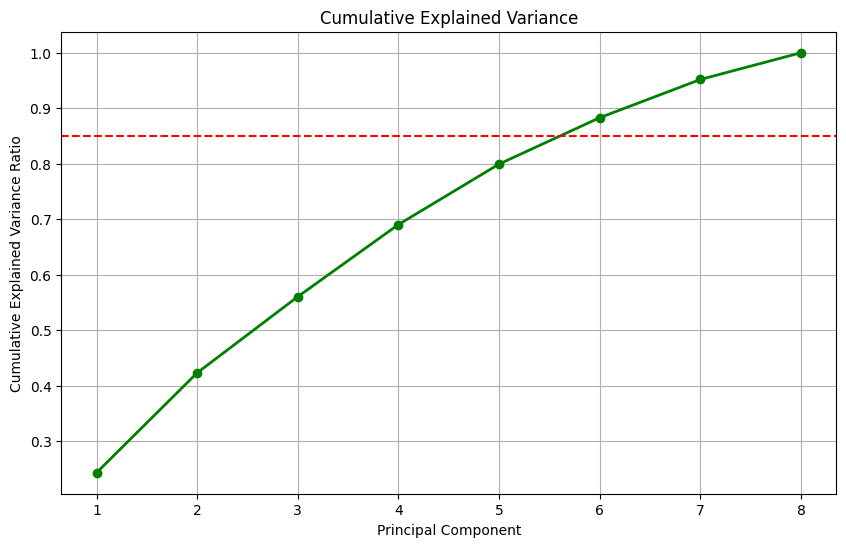

Number of components required to explain 85% of the variance: 6


In [34]:
import numpy as np

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', linewidth=2, color='green')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.85, color='r', linestyle='--')  # Add a horizontal line for 85% threshold
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_explained_variance >= 0.85) + 1
print(f"Number of components required to explain 85% of the variance: {n_components}")

6. Projecting on to our features

  From the plot, 6 features can explain 85% of the variance. Therefore, performing PCA and reduce the dimensionality of train and test features with 6 features.

In [35]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

7. Train a decision tree to classify genre

  Using a simple algorithm such as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the *logic flowchart* that the model generates from the training data.

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Train our decision tree
tree = DecisionTreeClassifier(random_state=13)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

8. Compare decision tree to a logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=13)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.65      0.63      0.64       218
        Rock       0.92      0.92      0.92       983

    accuracy                           0.87      1201
   macro avg       0.78      0.78      0.78      1201
weighted avg       0.87      0.87      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.54      0.64       218
        Rock       0.90      0.97      0.94       983

    accuracy                           0.89      1201
   macro avg       0.86      0.75      0.79      1201
weighted avg       0.89      0.89      0.88      1201



9. Balance our data for greater performance

  Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.

  By looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

  To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in sample size of our data points when weighting our classes here, and not relative importance of each class.

In [38]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=13)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=13)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

10. Check if balancing dataset improved model bias:
  - Check if model bias towards the "Rock" classification has been improved.  
  - Check for overall classification performance, as a lot of data points has been removed in this process

In [39]:
# Train decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=13)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train logistic regression on the balanced data
logreg = LogisticRegression(random_state=13)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.81      0.81       233
        Rock       0.80      0.79      0.79       222

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.75      0.79       233
        Rock       0.76      0.84      0.80       222

    accuracy                           0.79       455
   macro avg       0.80      0.79      0.79       455
weighted avg       0.80      0.79      0.79       455



11. Using cross-validation to evaluate our models

In [40]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                      ("tree", DecisionTreeClassifier(random_state=13))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                        ("logreg", LogisticRegression(random_state=13))])

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.743956043956044 Logistic Regression: 0.7862637362637361
